<a href="https://colab.research.google.com/github/sh3986/kaggle/blob/main/v4_keras_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Library

In [3]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:.5f}".format

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

import os
from os import listdir
from os.path import isfile, join
import cv2
from PIL import Image
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras import optimizers
tf.__version__

'2.8.2'

In [4]:
# Visualization
from tensorflow.keras.utils import plot_model

# Splitting data
from sklearn.model_selection import train_test_split

# Metrics 
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

import skimage.morphology as morp
from skimage.filters import rank

TensoFlow Version:  2.8.2


In [5]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn"

In [6]:
import os
os.chdir(data_path)

In [7]:
data = []
labels = []

height = 32
width = 32
channels = 3
num_classes = 43

In [ ]:
# for i in range(num_classes) :
#     path = f'./data/Train/{i}/'
#     Class = os.listdir(path)
#     for a in Class:
#         image = cv2.imread(path + a)
#         image_from_array = Image.fromarray(image, 'RGB')
#         size_image = image_from_array.resize((height, width))
#         data.append(np.array(size_image))
#         labels.append(i)

# data = np.array(data)
# labels = np.array(labels)

# import pickle
# with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_data.pkl","wb") as f:
#     pickle.dump(data, f)

# with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_label.pkl","wb") as f:
#     pickle.dump(labels, f)

### 데이터 로드

In [8]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_data.pkl","rb") as f:
    data = pickle.load(f)

import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_label.pkl","rb") as f:
    labels = pickle.load(f)

In [9]:
print(data.shape)
print(labels.shape)

(26010, 32, 32, 3)
(26010,)


### 탐색 분석

In [ ]:
X = data
y = tf.one_hot(labels, num_classes).numpy()

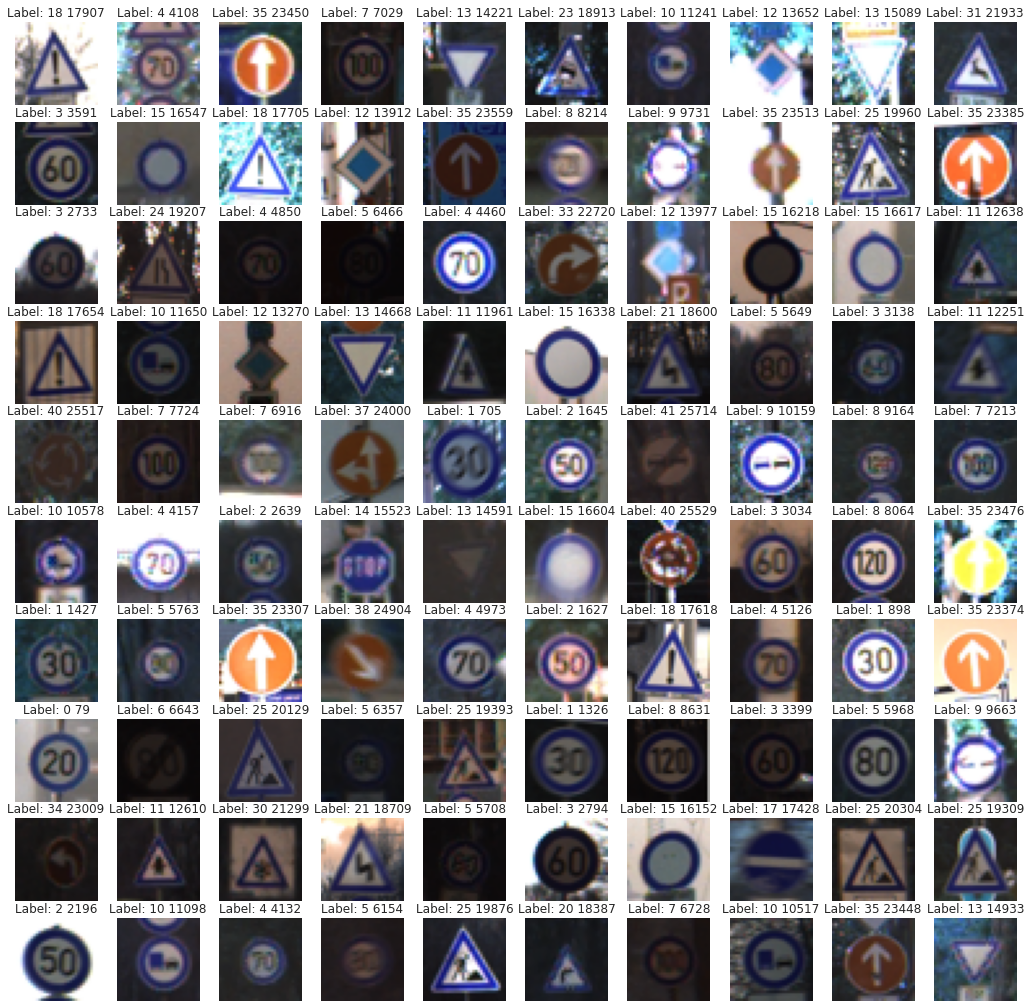

In [ ]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r]))+" "+str(r))

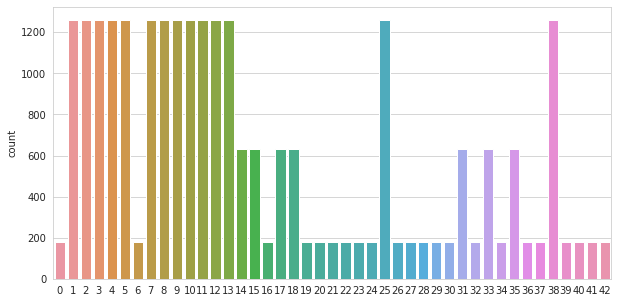

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(labels)

In [ ]:
uni_pattern = np.unique(labels, return_counts=True)
idxs = uni_pattern[0]
ratios = uni_pattern[1]/len(labels)

### 전처리

In [41]:
def Scaler(data_X,method = 'MinMax'):
  X = data_X.copy()
  X = X.astype(np.float64)

  if method == 'Divide255':
    X = X/255.0

  elif method == 'Standard':
    for a in X:
      for i in range(len(['r','g','b'])):
        mean_ = a[:,:,i].mean()
        std_ = a[:,:,i].std()
        a[:,:,i] = (a[:,:,i] - mean_)/std_

  elif method == 'MinMax':
    for a in X:
      for i in range(len(['r','g','b'])):
        max_ = a[:,:,i].max()
        min_ = a[:,:,i].min()
        a[:,:,i] = (a[:,:,i] - min_)/(max_ - min_)

  elif method == 'MinMax255':
    for a in X:
      for i in range(len(['r','g','b'])):
        max_ = a[:,:,i].max()
        min_ = a[:,:,i].min()
        a[:,:,i] = ((a[:,:,i] - min_)/(max_ - min_))*255
    return np.array(X,dtype='uint8')      

  return X

def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return np.array(image)

def img_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    image_from_array = Image.fromarray(final, 'RGB')
    size_image = image_from_array.resize((height, width))

    return np.array(size_image)

def preprocessing(data_X):
  data = []
  for img in data_X:
    img = img_contrast(to_grayscale_then_rgb(img))
    data.append(img)
  data = np.array(data)

  return data 

In [11]:
X = data
X = preprocessing(Scaler(X, 'MinMax255'))
y = tf.one_hot(labels, num_classes).numpy()

In [12]:
print(X.shape)
print(y.shape)

(26010, 32, 32, 3)
(26010, 43)


#### Data Augmentation

```python
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

# Prepare data-augmenting data generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        preprocessing_function=add_noise,
    )
```

In [13]:
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.6, 0.9],
    zoom_range=0.2,
    width_shift_range=0.2,    
    height_shift_range=0.2,
    fill_mode='nearest'
)

test_datagen  = ImageDataGenerator(
    rescale=1./255,
)

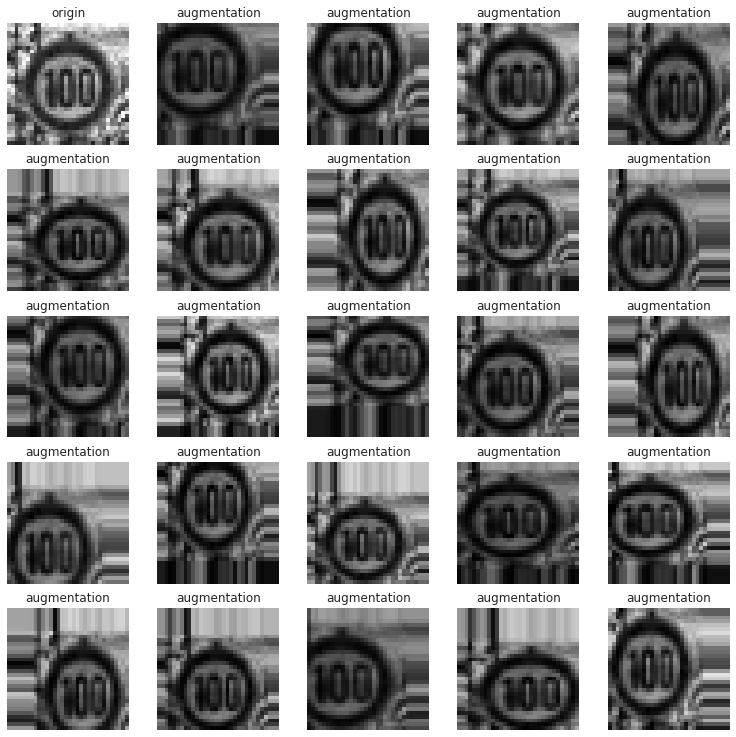

In [14]:
idx = 6768
input_img = X[idx]
input_label = y[idx]
input_img =  np.array([input_img]) 

generator = train_datagen.flow(input_img, batch_size=1)

f, axes = plt.subplots(5, 5, figsize=(13, 13))
ax_list = axes.flat
ax_list[0].imshow(input_img[0])
ax_list[0].axis('off')
ax_list[0].set_title("origin")

for i, img in enumerate(generator):
    ax_list[i+1].imshow(img[0])
    ax_list[i+1].axis('off')   
    ax_list[i+1].set_title("augmentation")
    if i > 22:
        break

#### Train, Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, shuffle=True, stratify=y)

In [17]:
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (20808, 32, 32, 3)
Test Shape : (5202, 32, 32, 3)


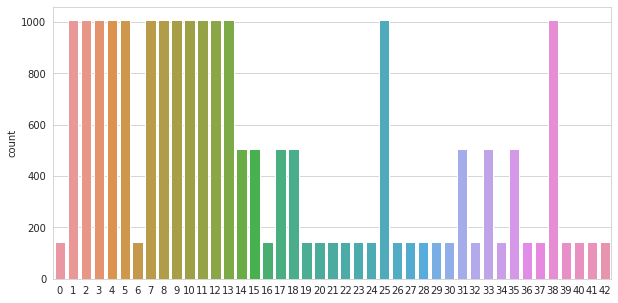

In [19]:
f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(np.argmax(y_train, axis=1))

#### Data OverSampling

In [22]:
from imblearn.over_sampling import RandomOverSampler 

train_rows=len(X_train)
X_train = X_train.reshape(train_rows,-1)

oversample = RandomOverSampler(random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)

X_train = X_train.reshape(-1,width, height,3)

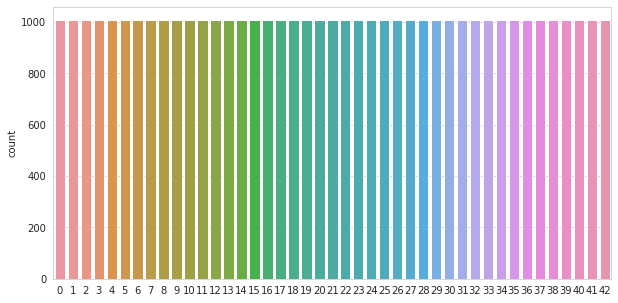

In [23]:
f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(np.argmax(y_train, axis=1))

### 모델 생성

In [24]:
train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size = 32
) 
validation_generator = test_datagen.flow(
        X_test, y_test,
        batch_size = 32
)

In [25]:
img_rows, img_cols = 32, 32
img_channels = 3
nb_classes = 43

In [26]:
resnet = ResNet50(weights= None, include_top=False, input_shape= (img_rows,img_cols,img_channels))

In [27]:
x = resnet.output
x = GlobalAveragePooling2D()(x) ## flatten 대신
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

In [ ]:
# model.summary()

In [ ]:
# plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

### 모델 학습

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model_check = ModelCheckpoint('best_model_v4.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)
# csv_logger = CSVLogger('train_log.csv', separator=',')

In [30]:
n_epochs = 50
history =  model.fit(
            train_generator, 
            batch_size = 32, epochs = n_epochs, verbose = 1, 
            validation_data=validation_generator, 
            callbacks = [model_check, early, reduce_lr])

Epoch 1/50
1355/1355 [==============================] - 61s 33ms/step - loss: 4.6057 - accuracy: 0.0796 - val_loss: 552.1984 - val_accuracy: 0.0233 - lr: 0.0010
Epoch 2/50
1355/1355 [==============================] - 45s 33ms/step - loss: 3.2428 - accuracy: 0.2600 - val_loss: 1.9653 - val_accuracy: 0.3652 - lr: 0.0010
Epoch 3/50
1355/1355 [==============================] - 42s 31ms/step - loss: 3.0003 - accuracy: 0.3137 - val_loss: 119.8329 - val_accuracy: 0.0175 - lr: 0.0010
Epoch 4/50
1355/1355 [==============================] - 42s 31ms/step - loss: 2.3809 - accuracy: 0.4335 - val_loss: 10.6113 - val_accuracy: 0.1157 - lr: 0.0010
Epoch 5/50
1355/1355 [==============================] - 43s 31ms/step - loss: 2.0944 - accuracy: 0.4795 - val_loss: 94.0410 - val_accuracy: 0.0196 - lr: 0.0010
Epoch 6/50
1355/1355 [==============================] - 42s 31ms/step - loss: 2.0319 - accuracy: 0.4778 - val_loss: 20.7892 - val_accuracy: 0.0490 - lr: 0.0010
Epoch 7/50
1355/1355 [=================

In [31]:
model_name = "model_resnet_augmentation_contrast_v4.h5"

In [32]:
model.save(model_name)

### 모델 평가

In [33]:
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow(
        X_test, y_test,
        batch_size = 32,
        shuffle=False
)

In [34]:
loss, acc = model.evaluate_generator(valid_generator)
print('Accuracy: ', acc, '\nLoss    : ', loss)

Accuracy:  0.9900038242340088 
Loss    :  0.04037750884890556


In [ ]:
from tensorflow import keras 
best_model = keras.models.load_model("best_model_v2.h5")

In [ ]:
loss, acc = best_model.evaluate_generator(valid_generator)
print('Accuracy: ', acc, '\nLoss    : ', loss)

Accuracy:  0.980199933052063 
Loss    :  0.06399103254079819


In [35]:
from sklearn.metrics import classification_report, confusion_matrix

valid_generator.reset()
y_pred = model.predict_generator(valid_generator)
y_pred = tf.argmax(y_pred, axis=1).numpy()

In [36]:
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.99      1.00      0.99       252
           2       0.99      0.97      0.98       252
           3       0.99      0.99      0.99       252
           4       1.00      0.98      0.99       252
           5       0.95      0.99      0.97       252
           6       1.00      1.00      1.00        36
           7       0.99      0.99      0.99       252
           8       0.98      0.99      0.99       252
           9       0.99      1.00      0.99       252
          10       1.00      0.98      0.99       252
          11       1.00      0.99      0.99       252
          12       0.99      0.98      0.99       252
          13       1.00      1.00      1.00       252
          14       1.00      0.99      1.00       126
          15       1.00      1.00      1.00       126
          16       1.00      1.00      1.00        36
          17       1.00    

In [37]:
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred, labels=range(9)))

[[ 36   0   0   0   0   0   0   0   0]
 [  0 251   0   0   0   1   0   0   0]
 [  0   0 244   0   0   7   0   0   0]
 [  0   0   1 249   0   1   0   0   0]
 [  0   1   2   0 247   1   0   0   0]
 [  0   0   0   2   0 250   0   0   0]
 [  0   0   0   0   0   0  36   0   0]
 [  0   1   0   0   0   1   0 249   1]
 [  0   0   0   0   0   0   0   2 250]]


In [ ]:
# q = len(list(history.history['loss']))
# plt.figure(figsize=(12, 6))
# sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
# sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
# plt.xlabel('#epochs')
# plt.ylabel('Training')
# plt.legend();

### 모델 테스트

In [ ]:
from tensorflow import keras 
model = keras.models.load_model(model_name)

### 테스트 데이터 예측

In [ ]:
# test_data = []
# file_name = []
# path = f'./data/Test/'
# Class = os.listdir(path)
# for a in Class:
#     image = cv2.imread(path + a)
#     image = img_contrast(image)
#     image_from_array = Image.fromarray(image, 'RGB')
#     size_image = image_from_array.resize((height, width))
#     test_data.append(np.array(size_image))
#     file_name.append(a)

# test_data = np.array(test_data)
# file_name = np.array(file_name)

# import pickle 

# with open('./data/test_data_contrast.pkl', 'wb') as f:
#     pickle.dump(test_data, f)

# with open('./data/file_name_contrast.pkl', 'wb') as f:
#     pickle.dump(file_name, f)

In [38]:
with open('./data/test_data_contrast.pkl', 'rb') as f:
    test_data = pickle.load(f)

with open('./data/file_name_contrast.pkl', 'rb') as f:
    file_name = pickle.load(f)

In [42]:
test_data_origin = test_data

In [43]:
test_data = preprocessing(Scaler(test_data, 'MinMax255'))
test_data.shape

(8670, 32, 32, 3)

In [44]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(
        test_data,
        batch_size = 32,
        shuffle=False
) 

In [45]:
test_generator.reset()
test_label = model.predict_generator(test_generator)
test_label = tf.argmax(test_label, axis=1).numpy()

In [46]:
def show_label_image(data, label, file_name, category):
    fig, axes = plt.subplots(nrows = 10, ncols = 10, figsize=(18, 18))
    img_filter = np.argwhere(label==category).reshape(-1)
    img = data[img_filter]
    name = file_name[img_filter]
    index = np.random.choice(list(range(len(img))), 100)
    for i, ax in enumerate(axes.flat):
        r = index[i]
        ax.imshow(img[r])
        ax.set_title(name[r], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show() 

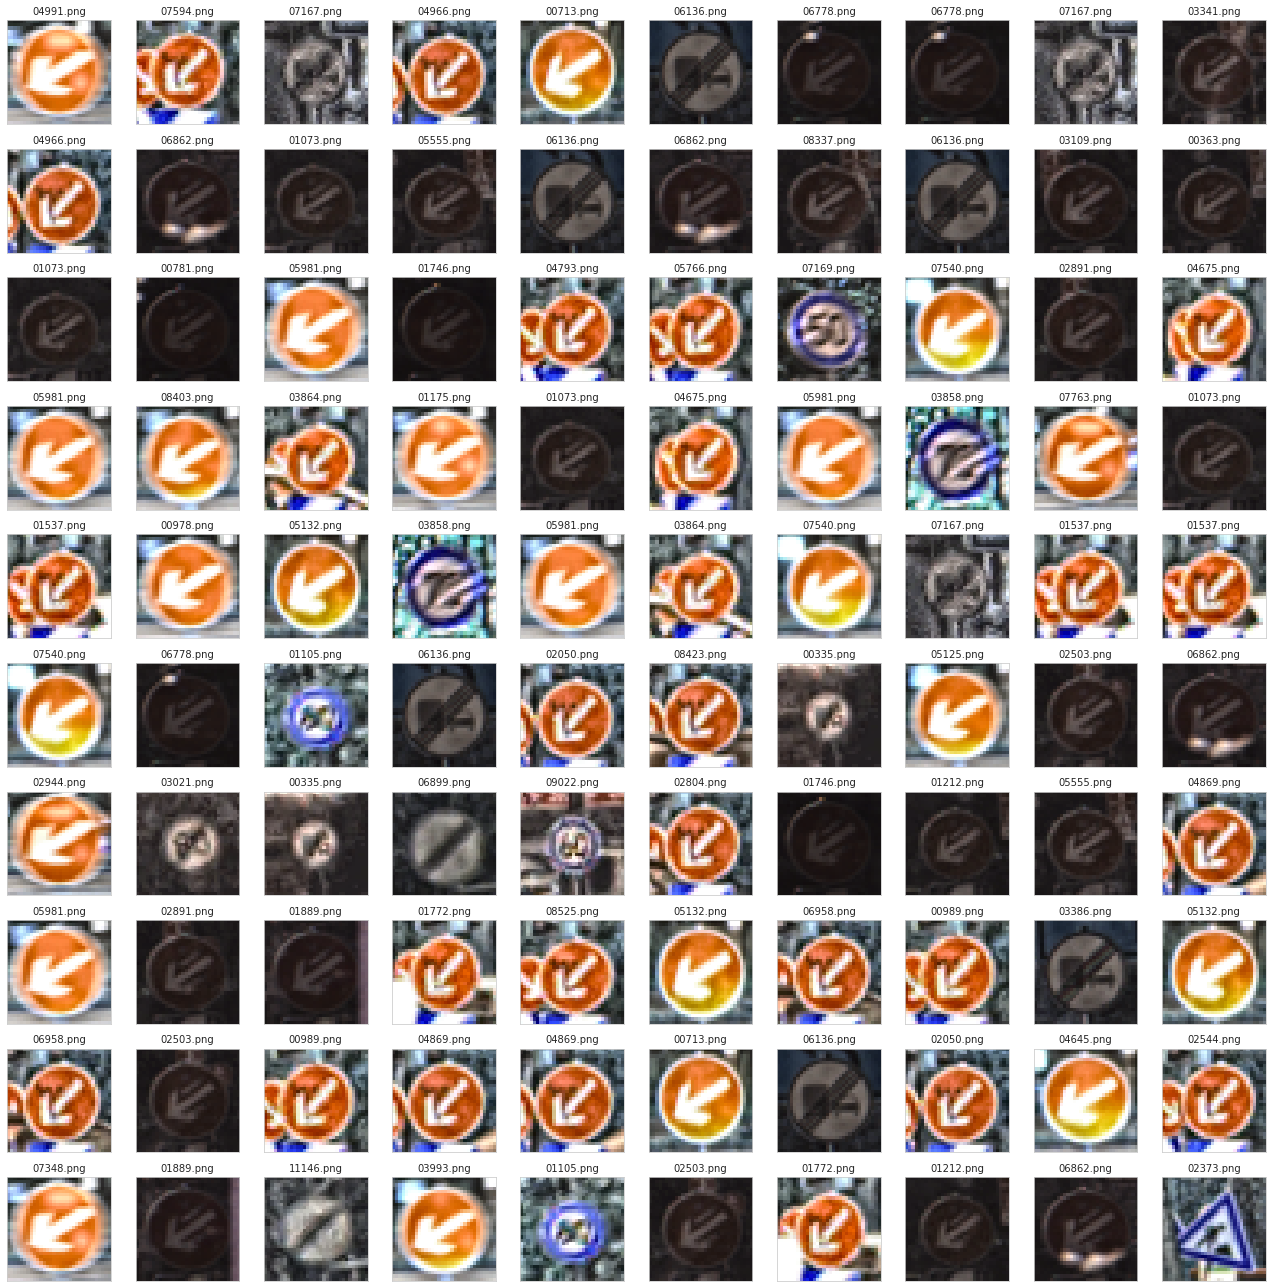

In [47]:
show_label_image(test_data_origin, test_label, file_name, 39)

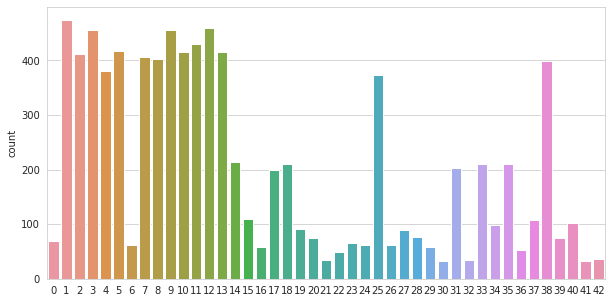

In [48]:
f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(test_label)

In [49]:
csv_data = pd.DataFrame(np.concatenate((file_name.reshape(-1, 1), test_label.reshape(-1,1)), axis=1))

In [50]:
csv_data = csv_data.sort_values(by=[0])
csv_data.head()

,0,1
279,00000.png,16
8119,00001.png,1
3628,00002.png,38
1565,00003.png,33
5360,00004.png,11


In [54]:
csv_data.to_csv("predicted_output_v4.csv", header=False, index=False)

In [55]:
from google.colab import files
files.download("predicted_output_v4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 주석